In [1]:
import pandas as pd
import numpy as np
from numpy import ma
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.cluster.hierarchy import dendrogram, fcluster
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

from sklearn.datasets import load_iris
iris_data = load_iris(return_X_y=False, as_frame=True)
iris_data.data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [3]:
X = iris_data.data
target_labels = iris_data

In [4]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix

In [56]:
from hierarchical_clustering import AgglomerativeClustering

linkage_types = ['ward', 'complete', 'average', 'single']
hclust = dict()
for linkage_type in linkage_types:
    model = AgglomerativeClustering(linkage=linkage_type)
    clustering = model.fit(X)
    hclust[linkage_type] = clustering

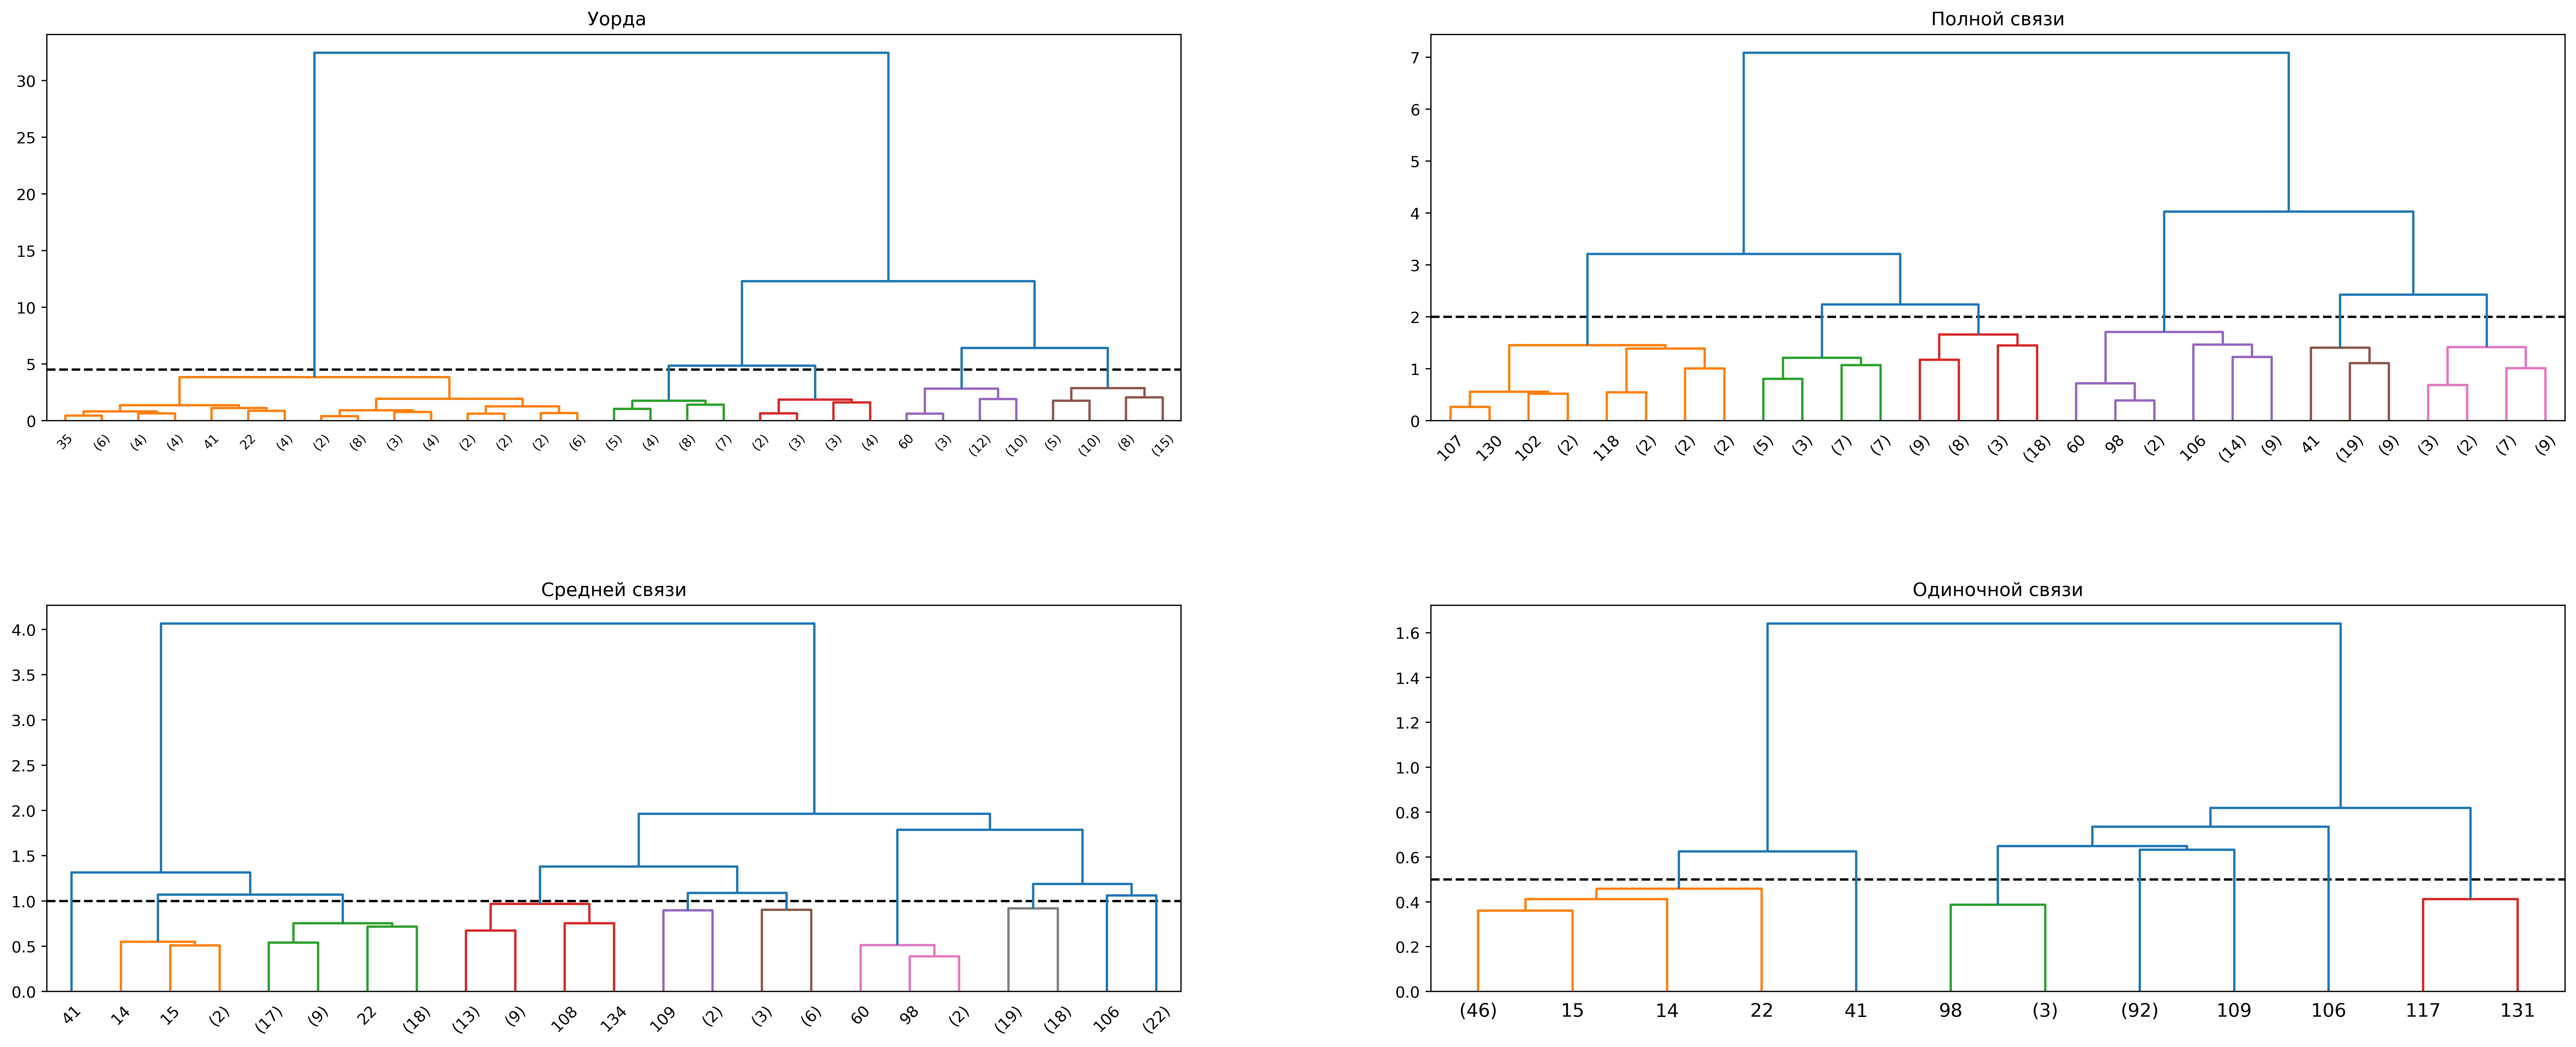

In [78]:
cutoff_thresholds = [4.5, 2, 1, 0.5]
linkage_colors = dict(zip(linkage_types, cutoff_thresholds))
labels = [' Уорда', 'Полной связи', "Средней связи", "Одиночной связи"]
linkage_labels = dict(zip(linkage_types, labels))

mpl.rcParams.update(mpl.rcParamsDefault)
fig, axs = plt.subplots(2, 2)
axs_indices = [(i, j) for i in range(2) for j in range(2)]
for linkage_type, axs_ind in zip(linkage_types, axs_indices):
    axs[axs_ind].set_title(linkage_labels[linkage_type])
    axs[axs_ind].axhline(y=linkage_colors[linkage_type], linestyle='dashed', color='black')
    linkage_matrix = plot_dendrogram(
        model=hclust[linkage_type],
        truncate_mode="level",
        p=4,
        ax=axs[axs_ind],
        labels=None,
        color_threshold = linkage_colors[linkage_type]
        )
    
fig.tight_layout()
fig.set_size_inches(25, 10.5)
fig.set_dpi(400)
plt.show()

In [73]:
from sklearn.cluster import AgglomerativeClustering as AC_sklearn

linkage_types = ['ward', 'complete', 'average', 'single']
hclust_sklearn = dict()
for linkage_type in linkage_types:
    model = AC_sklearn(linkage=linkage_type, n_clusters=None,
                                    distance_threshold=0,
                                    compute_distances=True)
    clustering = model.fit(X)
    hclust_sklearn[linkage_type] = clustering

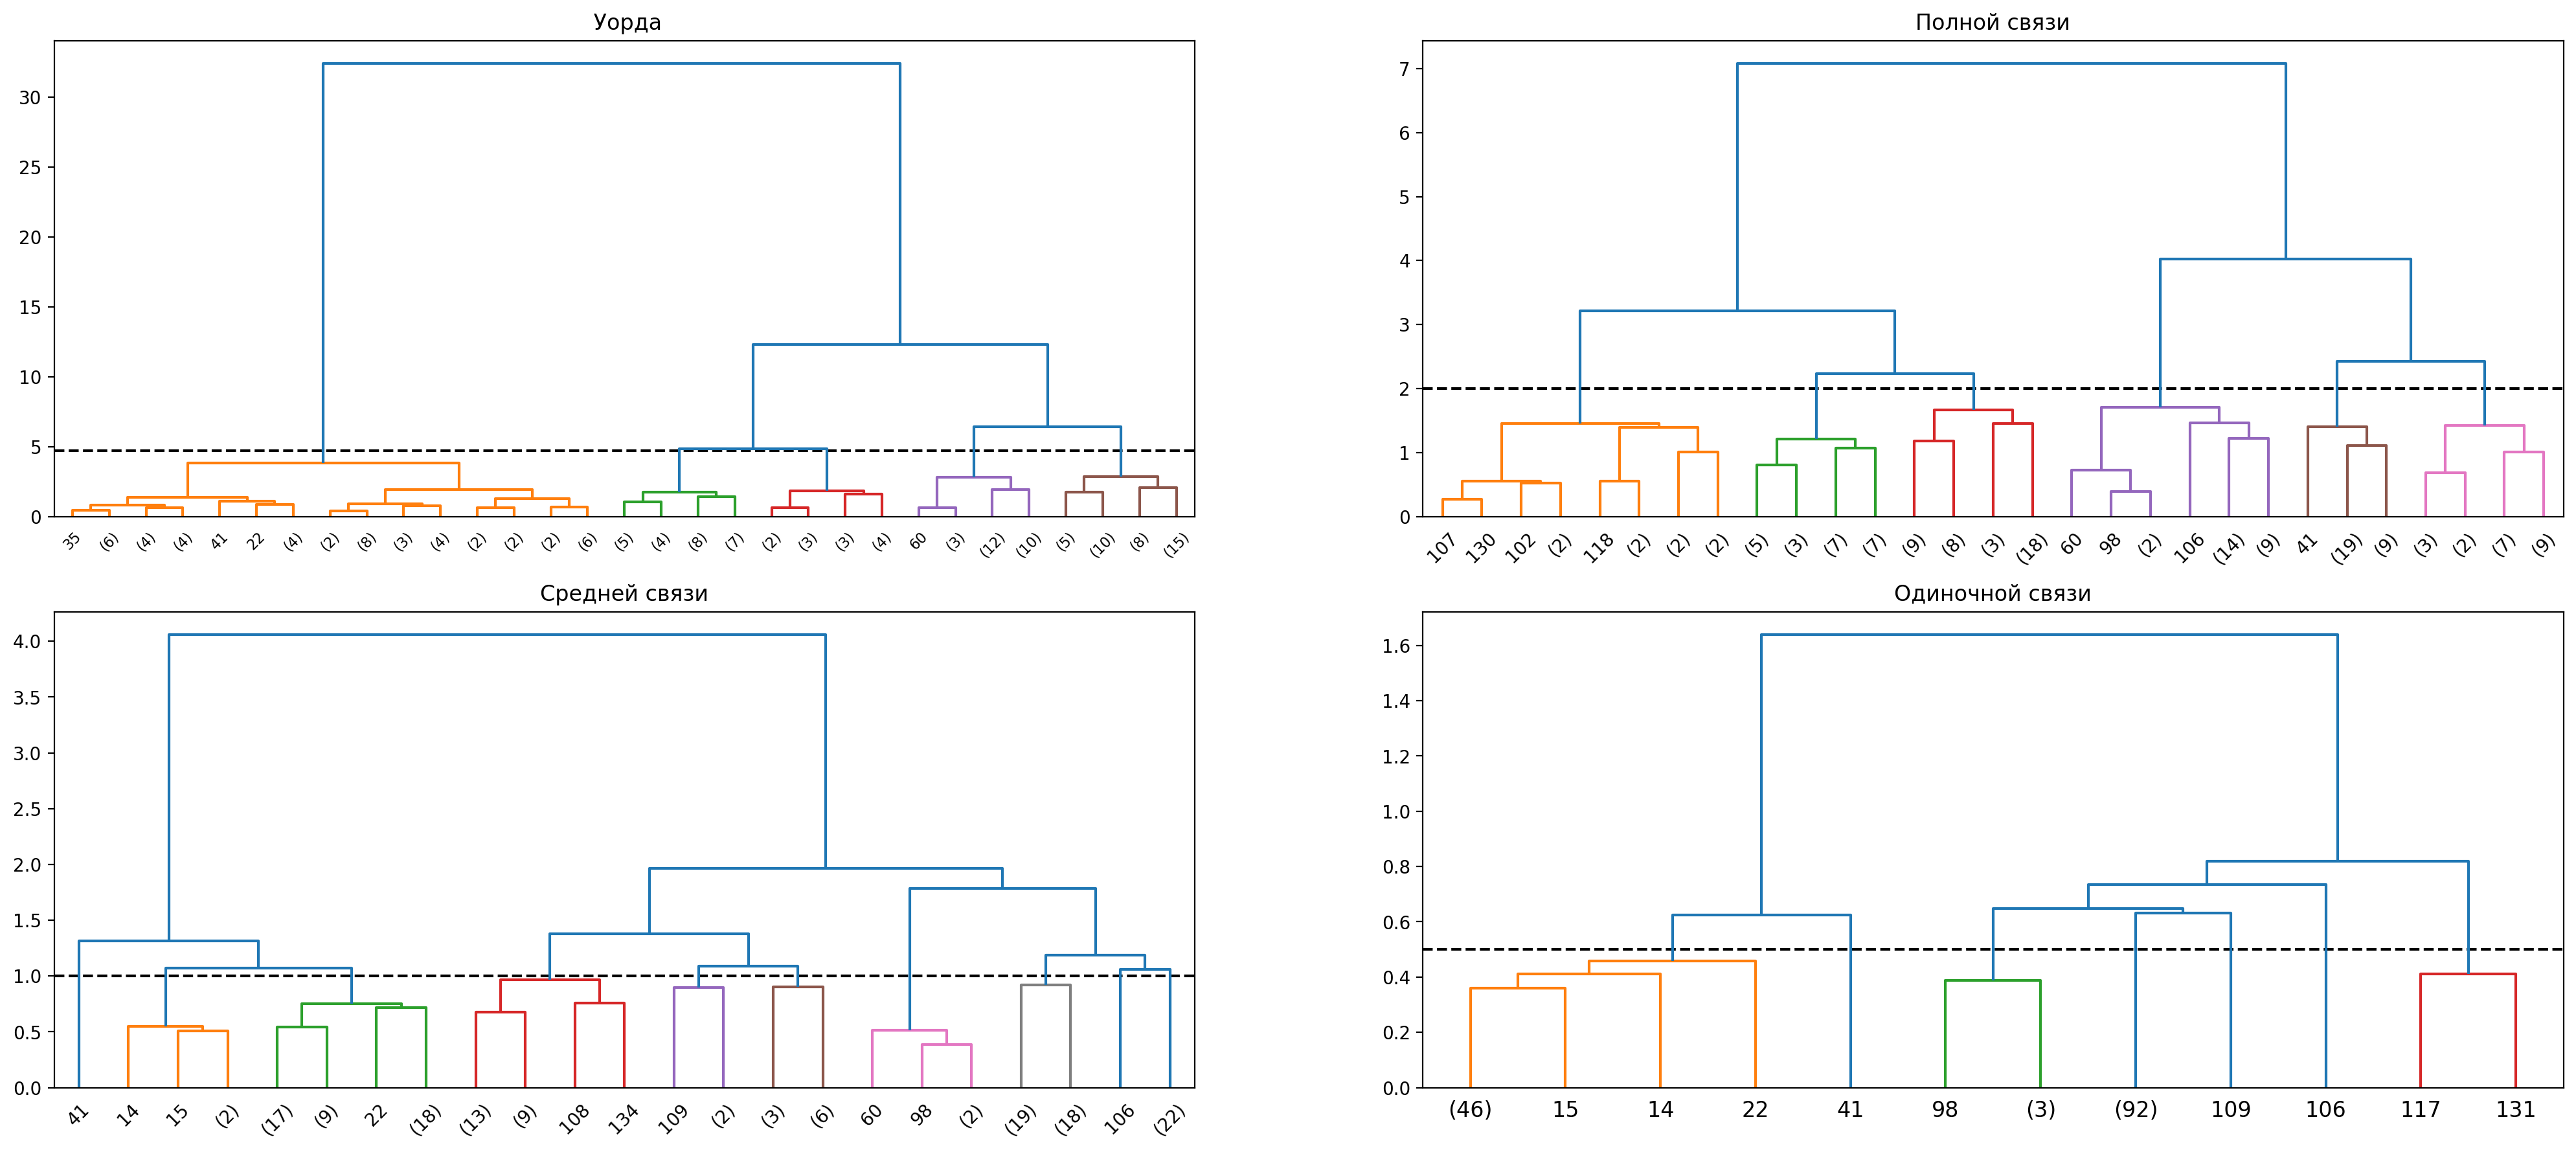

In [75]:
mpl.rcParams.update(mpl.rcParamsDefault)
fig, axs = plt.subplots(2, 2)
axs_indices = [(i, j) for i in range(2) for j in range(2)]
for linkage_type, axs_ind in zip(linkage_types, axs_indices):
    axs[axs_ind].set_title(linkage_labels[linkage_type])
    axs[axs_ind].axhline(y=linkage_colors[linkage_type], linestyle='dashed', color='black')
    linkage_matrix = plot_dendrogram(
        model=hclust_sklearn[linkage_type],
        truncate_mode="level",
        p=4,
        ax=axs[axs_ind],
        labels=None,
        color_threshold = linkage_colors[linkage_type]
        )
    
fig.set_size_inches(25, 10.5)
fig.set_dpi(200)
plt.show()